# This notebook executes in ~45 mins on an i7-7700HQ but in ~63 mins on google colab


In [ ]:
import zipfile
import os
import numpy as np
from matplotlib import pyplot as plt
import re

# Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

# If you are using Colab un-comment the cell below

In [ ]:
if 'att-database-of-faces.zip' not in os.listdir():
  !pip install kaggle
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d kasikrit/att-database-of-faces

In [ ]:
def unzip_file(path, new_dir_name):
  with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(new_dir_name)

In [ ]:
if 'Dataset' not in os.listdir():
  try:
    unzip_file('./Dataset.zip', 'Dataset')
  except FileNotFoundError:
    unzip_file('./att-database-of-faces.zip', 'Dataset')

# Creating the data matrix

In [ ]:
def create_data_and_labels():
  '''
  Loops through the Dataset directory and extracts the images for each person of size 112x92
  Then, flattens each image to give out a 1x10304 vector
  Finally, gets the labels of each image from the path of the image and puts it into a labels vector
  returns a tuple (data, labels):
    data: (400, 10304) numpy array that represents the flattened images corresponding to the sorted labels 
    labels: (400, ) vector that represents the sorted labels from 1 to 40 
  '''
  sub_dir = [] # this is a list where the elements are of the format 'Dataset/s1' or 'Dataset/s12' and so on

  all_img_paths = [] # this is a list where the elements are of the format 'Dataset/s1/1.pgm' or 'Dataset/s12/9.pgm' and so on
 
  data = []  # a list that will be converted into numpy array later, that holds the data
  
  labels = [] # a list that wlil be converted into numpy array later, that holds the labels

  # the first directory that would be read in os.walk is 'Dataset', this boolean is set to false
  # to discard this directory name and start from names like Dataset/s1 and so on
  first_dir = False

  for x in os.walk('Dataset'):
    if not first_dir:
      first_dir = True #disregard the first directory
      continue
    sub_dir.append(x[0])

  sub_dir.sort()
  for sub in sub_dir:
    # forms the full path of one image for all images in the dataset
    all_img_paths.append([(sub + '/' + f) for f in os.listdir(sub) if os.path.isfile(os.path.join(sub, f))])
  
  all_img_paths.sort()
  # print(all_img_paths)
  for img_paths_per_person in all_img_paths:
    img_paths_per_person.sort()
    for img in img_paths_per_person:
      # spliting the path on the delimiter '/' and selecting the string that has s + a number (s11, s4) just to select just that number
      # and append it into the labels list
      try:
        img_label = int(re.split('/', img)[1][1:]) # Deals with how the path name looks in colab environment. (Probably)
      except ValueError:
        img_label = int(re.split('/', img)[0][9:]) # Deals with how the full path name looks in windows 

      labels.append(img_label)
      # flatten to make the image into (10304, ) vector
      data.append(plt.imread(img).flatten())
  
  # Turning the lists into numpy arrays 
  data = np.asarray(data, dtype = 'int32')
  labels = np.asarray(labels, dtype = 'int32').reshape(400, 1)

  return data, labels

(400, 10304)
(400, 1)
[1]


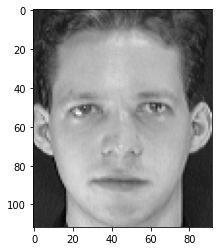

In [ ]:
data, labels = create_data_and_labels()
print(data.shape)
print(labels.shape)
plt.imshow(data[0].reshape(112, 92), cmap='gray')
print(labels[0])

# A custom function to do the 50-50 split for train and test data as required in the Assignment

In [ ]:
def custom_train_test_split(data, labels):
  '''
  This function keeps the odd rows for training and even rows for testing
  50%-50% split for training and testing data
  returns a tuple:
    train_data
    train_labels
    test_data
    test_labels
  '''
  train_data = np.zeros((int(data.shape[0]/2), data.shape[1]))
  test_data = np.zeros((int(data.shape[0]/2), data.shape[1]))
  train_labels = np.zeros((int(labels.shape[0]/2)))
  test_labels = np.zeros((int(labels.shape[0]/2)))
  i = 0
  j = 0
  for index in range(data.shape[0]):
    if index%2 == 0:
      test_data[i] = data[index]
      test_labels[i] = labels[index]
      i+=1
    else:
      train_data[j] = data[index]
      train_labels[j] = labels[index]
      j+=1
  return train_data, train_labels, test_data, test_labels

In [ ]:
train_data, train_labels, test_data, test_labels = custom_train_test_split(data, labels)
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)
assert not np.allclose(train_data, test_data)

(200, 10304)
(200, 10304)
(200,)
(200,)


# KNN for classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def K_nearest_neighbours(A_train, train_labels, A_test, test_labels, k_neighbours, alpha = -1, benchmark = False, original_test_data = []):
  '''
  The function uses sklearn's KNeighborsClassifier to fit and predict the labels of the test data
  inputs:
    A_train: (n, m) nd-array where m is the number of dominant dimensions and (n) is number of data elements, A_train is the projected instances of training data for a single alpha
    train_labels: (n,) nd-array which are the labels of the training data
    A_test: (n, m) nd-array where m is the number of dominant dimensions, A_test is the projected instances of testing data for a single alpha
    test_labels: (n,) nd-array which are the labels of the testing data
    k_neighbours: a list that represents the number of neighbours that would be taken into account during classification
    alpha: the threshold that caused the dimension reduction
    benchmark: is True when using the 2 benchmark functions otherwise just don't use it
  at the end the function plots the number of neighbours against accuracy
  '''
  accuracies = []
  for i,neighbour in zip(range(len(k_neighbours)),k_neighbours):
    model = KNeighborsClassifier(n_neighbors = neighbour)
    model.fit(A_train, train_labels)
    pred = model.predict(A_test)
    accuracies.append(accuracy_score(pred, test_labels)) 
    print(f"Accuracy score is: {accuracies[i]} for {neighbour} neighbours")
    count = 0
    wrongly_predicted_classes = []
    for k in range(len(pred)):
    #   print(f"pred: {int(pred[k])} ----- True: {int(test_labels[k])}", end=" ")
      if pred[k] != test_labels[k]:
        # print("-------> Wrong Prediciton")
        count += 1
        if benchmark == True and (pred[k] not in wrongly_predicted_classes):
          wrongly_predicted_classes.append(pred[k])
          plt.imshow(original_test_data[k].reshape(112, 92), cmap='gray')
          plt.title(f"The model predicted {pred[k]} but it was {test_labels[k]}")
          plt.show()
    print(f"wrong prediction = {count} for {neighbour} neighbours")
  if benchmark == False:
    plt.plot(k_neighbours,accuracies)
    if alpha >= 0: # alpha is initialized with -1 just so if we don't need to plot according to alpha
      plt.title(f"alpha = {alpha}")
    else:
      plt.title(f"Using Multi-Class LDA")
    plt.xlabel("number of neighbours")
    plt.ylabel("accuracy")
    plt.show()
  else:
    return accuracies[0]

# the PCA functions

In [ ]:
def try_alphas(eig_vals, alpha):
  '''
  Following the Pseudo Code of PCA this function
  gets a value (r) where the ratio between the sum of the first largest eigen values and the sum of all eigen values
  is bigger than or equal the threshold alpha
  returns:
    r: the value that staisfiy the ratio inequality 
  '''
  r = 0
  total_eig_vals = sum(eig_vals)
  f_r = eig_vals[r] / total_eig_vals
  
  while f_r < alpha and r <= eig_vals.shape[0]:
    r += 1
    f_r = sum(eig_vals[:r]) / total_eig_vals
  
  return r

In [ ]:
def PCA(train_data, test_data, alphas, cache = []):
  '''
  Principal Componenet Analysis: Reduces the number of dimensions taken to represent the train_data
  input:
    train_data: a (n, 10304) nd-array where PCA will decrease the number of dimensions and replace it with projected instances of smaller dimensions using a projection matrix U
    test_data: a (n, 10304) nd-array where the projection matrix U will project test_data on the new dimensions
    alphas: a list of thresholds that determines the number of dimensions after reduction
    cache: was just for debugging, just by looking at the code you might understand what it was doing, but it doesn't serve any major purpose
  returns:
    A_train_per_alpha: a list of nd-arrays where each element is a projected instances of train_data on the new dimensions that correspondes to a single alpha
    A_test_per_alpha: a list of nd-arrays where each element is a projected instances of test_data on the new dimensions that correspondes to a single alpha
  '''
  mu_train = np.mean(train_data, axis = 0)
  Z_train = train_data - mu_train
  COV = np.cov(Z_train.T, bias = True)
  if len(cache) == 0:
    eig_vals, eig_vecs = np.linalg.eigh(COV)
    cache.append((eig_vals, eig_vecs))
  else:
    eig_vals, eig_vecs = cache[0][0], cache[0][1]
  sort = np.argsort(eig_vals)[::-1]
  # sorting the eigen values in descending order
  eig_vals = eig_vals[sort]
  # sorting the eigen vectors in descending order of eigen values
  eig_vecs = eig_vecs[:,sort]
  sing_vals = np.arange(120) + 1
  plt.plot(sing_vals, eig_vals[:120], 'ro-', linewidth=2)
  plt.title('Scree Plot')
  plt.xlabel('Principal Component')
  plt.ylabel('Eigenvalue')
  A_train_per_alpha = []
  A_test_per_alpha = []
  for alpha in alphas:
    r = try_alphas(eig_vals, alpha) 
    U = eig_vecs[:, :r]   # The projection matrix
    A_train = (U.T @ train_data.T).T  # Projected instances of training data for a single alpha
    A_test = (U.T @ test_data.T).T  # Projected instances of testing data for a single alpha
    A_train_per_alpha.append(A_train)
    A_test_per_alpha.append(A_test)
  return A_train_per_alpha, A_test_per_alpha, cache

# Running PCA and it's classification

In [ ]:
try: 
  print(len(cache2))
except NameError:
  cache2 = []

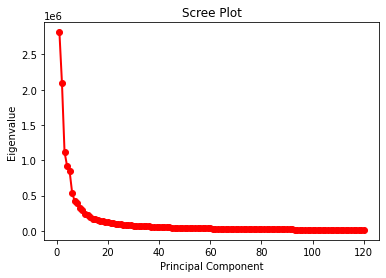

In [ ]:
alphas = [0.8, 0.85, 0.9, 0.95]
A_train_per_alpha, A_test_per_alpha, cache2  = PCA(train_data, test_data, alphas, cache2)

Accuracy score is: 0.94 for 1 neighbours
wrong prediction = 12 for 1 neighbours
Accuracy score is: 0.825 for 3 neighbours
wrong prediction = 35 for 3 neighbours
Accuracy score is: 0.805 for 5 neighbours
wrong prediction = 39 for 5 neighbours
Accuracy score is: 0.77 for 7 neighbours
wrong prediction = 46 for 7 neighbours


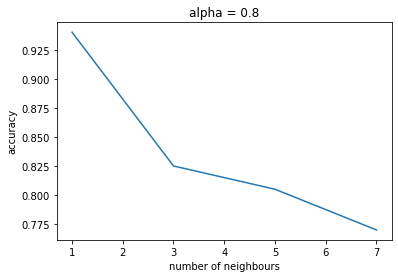

Accuracy score is: 0.945 for 1 neighbours
wrong prediction = 11 for 1 neighbours
Accuracy score is: 0.845 for 3 neighbours
wrong prediction = 31 for 3 neighbours
Accuracy score is: 0.795 for 5 neighbours
wrong prediction = 41 for 5 neighbours
Accuracy score is: 0.785 for 7 neighbours
wrong prediction = 43 for 7 neighbours


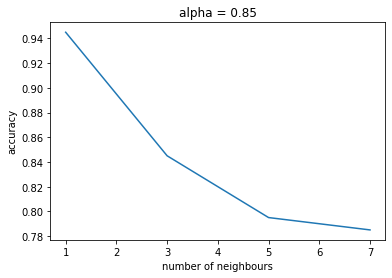

Accuracy score is: 0.94 for 1 neighbours
wrong prediction = 12 for 1 neighbours
Accuracy score is: 0.85 for 3 neighbours
wrong prediction = 30 for 3 neighbours
Accuracy score is: 0.8 for 5 neighbours
wrong prediction = 40 for 5 neighbours
Accuracy score is: 0.775 for 7 neighbours
wrong prediction = 45 for 7 neighbours


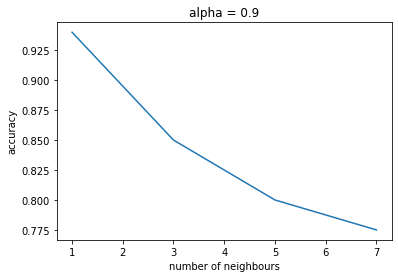

Accuracy score is: 0.935 for 1 neighbours
wrong prediction = 13 for 1 neighbours
Accuracy score is: 0.855 for 3 neighbours
wrong prediction = 29 for 3 neighbours
Accuracy score is: 0.79 for 5 neighbours
wrong prediction = 42 for 5 neighbours
Accuracy score is: 0.775 for 7 neighbours
wrong prediction = 45 for 7 neighbours


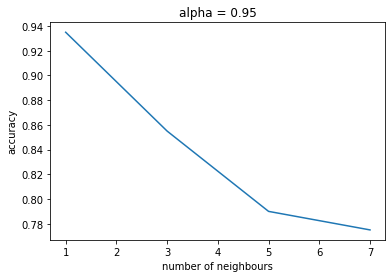

In [ ]:
k_neighbours = [1, 3, 5, 7]
for A_train, A_test, alpha in zip(A_train_per_alpha, A_test_per_alpha, alphas):
  K_nearest_neighbours(A_train, train_labels, A_test, test_labels, k_neighbours, alpha)

# Helper Functions for doing LDA

In [ ]:
def get_mean_per_label(train_data, train_labels, num_classes = 40):
  '''
  Forms a (n, m) nd-array where (n) is number of attributes of the data and (m) is the number of class labels 
  each element[i, j] represent the mean of attribute (i) within class (j)
  num_classes initialized to 40 because that is the number of classes in the data set, but when solving faces vs non-faces problem
  num_classes will be called with num_classes = 2 <------ this is the responsibilty of the programmer
  '''
  n = train_data.shape[1]
  m = num_classes
  mean_per_label = np.zeros((n, m))
  for i in range(m):
    x = train_data[train_labels == i+1]
    mean_per_label[:, i] = np.mean(x, axis = 0)

  return mean_per_label

In [ ]:
def compute_S(train_data, train_labels, mean_vectors, num_classes = 40):
  '''
  Computes the within class scatter matrix
  mean_vectors: the (n, m) where each element[i, j] represent the mean of attribute (i) within class (j)
  returns:
    S: a (n, n) nd-array where (n) is the num of attributes
  '''
  m = num_classes
  n = train_data.shape[1]
  S = np.zeros((n, n))
  for i in range(m):
    Z = train_data[train_labels == i+1] - mean_vectors[:, i].reshape(n, 1).T
    # class_scatter = np.cov(Z.T, bias = True)
    class_scatter = Z.T @ Z
    S += class_scatter
  
  return S

In [ ]:
def compute_Sb(train_data, train_labels, mean_vectors, num_classes = 40):
  '''
  Computes the between class scatter matrix Sb
  returns:
    S_b: a (n, n) nd-array where (n) is the num of attributes
  '''
  m = num_classes
  n = train_data.shape[1]
  mu_overall = np.mean(train_data, axis = 0).reshape(n, 1)
  S_b = np.zeros((n, n))
  for k in range(m):
    n_k = train_data[train_labels == k+1, :].shape[0]
    mu_k = mean_vectors[:, k].reshape(n, 1)
    S_b += n_k * (mu_k - mu_overall) @ (mu_k - mu_overall).T
  
  return S_b

In [ ]:
def LDA(train_data, train_labels, test_data, num_classes, cache):
  """
  Performs Linear discriminent analysis
  """
  if len(cache) == 0:
    # compute the mean vector per label matrix
    mu_per_label = get_mean_per_label(train_data, train_labels, num_classes = num_classes)
    # compute the between class scatter matrix Sb takes 15 ~ 20 secs on colab
    S_b = compute_Sb(train_data, train_labels, mu_per_label, num_classes = num_classes)
    # compute the withint class scatter matrix S takes 25 ~ 30 secs on colab
    S = compute_S(train_data, train_labels, mu_per_label, num_classes = num_classes)
    # get inverse of S
    S_inv = np.linalg.inv(S)
    # get eigen values and eigen vectors from S_inv @ S_b takes 5 ~ 6 mins on colab but 2 ~ 3 mins on local
    eig_vals, eig_vecs = np.linalg.eigh(S_inv @ S_b)
    cache.append((eig_vals, eig_vecs))
  else:
    eig_vals, eig_vecs = cache[0][0], cache[0][1]
  sort = np.argsort(eig_vals)[::-1]
  # sorting the eigen values in descending order
  eig_vals = eig_vals[sort]
  # sorting the eigen vectors in descending order of eigen values
  eig_vecs = eig_vecs[:,sort]
  # choose the first num_classes-1 eig_vals and their corresponding eig_vecs
  U = eig_vecs[:, :num_classes - 1]
  A_train = (U.T @ train_data.T).T  # Projected instances of training data
  A_test = (U.T @ test_data.T).T  # Projected instances of testing data
  return A_train, A_test, cache

# Run LDA

In [ ]:
try:
  print(len(cache1))
except NameError:
  cache1 = []

In [ ]:
A_train, A_test, cache1 = LDA(train_data, train_labels, test_data, num_classes=40, cache = [])

Accuracy score is: 0.935 for 1 neighbours
wrong prediction = 13 for 1 neighbours
Accuracy score is: 0.865 for 3 neighbours
wrong prediction = 27 for 3 neighbours
Accuracy score is: 0.815 for 5 neighbours
wrong prediction = 37 for 5 neighbours
Accuracy score is: 0.81 for 7 neighbours
wrong prediction = 38 for 7 neighbours


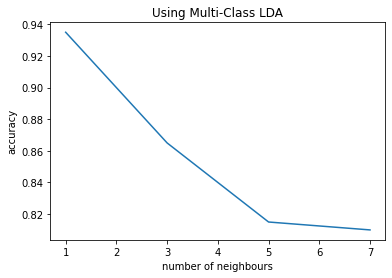

In [ ]:
k_neighbours = [1, 3, 5, 7]
K_nearest_neighbours(A_train, train_labels, A_test, test_labels, k_neighbours)

# Faces vs Non-Faces

In [ ]:
if 'non-faces-new' not in os.listdir():
  try:
    unzip_file('./non-faces.zip', 'non-faces-new')
  except FileNotFoundError:
    print("get the non-faces.zip that I sent you and put it in the same directory!")

In [ ]:
def get_non_faces_images():
  '''
  Loops through the Dataset directory and extracts the images for each person of size 112x92
  Then, flattens each image to give out a 1x10304 vector
  Finally, gets the labels of each image from the path of the image and puts it into a labels vector
  returns a tuple (data, labels):
    data: (600, 10304) numpy array that represents the flattened images corresponding to the sorted labels 
  '''
  sub_dir = [] 

  all_img_paths = [] 
 
  data = []  # a list that will be converted into numpy array later, that holds the data

  first_dir = False

  for x in os.walk('non-faces-new'):
    if not first_dir:
      first_dir = True #disregard the first directory
      continue
    sub_dir.append(x[0])

  for sub in sub_dir:
    # forms the full path of one image for all images in the dataset
    all_img_paths.append([(sub + '/' + f) for f in os.listdir(sub) if os.path.isfile(os.path.join(sub, f))])

  for img_paths in all_img_paths:
    for img in img_paths:
      l = plt.imread(img)
      # the image's shape has 3 dimensions because it has color, so just getting one dimension is enough to make it in black and white
      l = l[:,:, 0].reshape(112, 92)
      # flatten to make the image into (10304, ) vector
      data.append(l.flatten())

  
  # Turning the lists into numpy arrays 
  data = np.asarray(data, dtype = 'int32')
  np.random.seed(112)
  np.random.shuffle(data)

  return data

In [ ]:
non_faces = get_non_faces_images()
print(non_faces.shape)

(600, 10304)


In [ ]:
def create_new_dataset(faces, non_faces):
  size_of_faces = faces.shape[0]
  size_of_non_faces = non_faces.shape[0]
  # make faces of label 1
  label1 = np.ones((size_of_faces, 1))
  # make non_faces of label 2
  label2 = 2 * np.ones((size_of_non_faces, 1))
  # stack them together
  labels = np.vstack((label1, label2))
  # stack faces and non_faces together
  data = np.vstack((faces, non_faces))
  return data, labels

In [ ]:
def LDA_non_faces_vs_faces_benchmark(faces, non_faces, num_non_faces, caches = []):
  '''
  This function is to answer question 7)a)iii 
  num_non_faces: a list of how many non_face images will be used per iteration
  faces: the faces dataset
  non_faces: the non faces dataset
  returns:
    accuracy_per_num_non_faces: a list of the accuracies per the elements in num_non_faces list
    caches = a list of the caches for each iteration of LDA
  '''
  accuracy_per_num_non_faces = []
  # I think this initial shuffle is what made the accuracy very good for LDA benchmark
  np.random.seed(112)
  np.random.shuffle(non_faces)
  for n in num_non_faces:
    x = []
    # get dataset having n number of non_face images n will be [100, 200, 300, 400, 500, 600]
    new_data, new_labels = create_new_dataset(faces = faces, non_faces = non_faces[:n])
    # use 50-50 split to split new_data into train and test data
    new_train_data, new_train_labels, new_test_data, new_test_labels = custom_train_test_split(new_data, new_labels)
    # perform LDA
    A_train1, A_test1, x = LDA(new_train_data, new_train_labels, new_test_data, num_classes=2, cache = x)
    # get accuracy by KNN for k_neighbours = 3
    print(f"accuracy for {n} non face images")
    acc = K_nearest_neighbours(A_train1, new_train_labels, A_test1, new_test_labels, k_neighbours = [3], benchmark = True, original_test_data = new_test_data)
    print("========================================================")
    # append the acc to the accuracy list so that we can plot it when the loop is finished
    accuracy_per_num_non_faces.append(acc)
  
  return accuracy_per_num_non_faces

In [ ]:
try:
  print(len(caches))
except NameError:
  caches = []

0


accuracy for 100 non face images
Accuracy score is: 0.996 for 3 neighbours


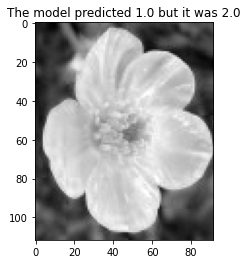

wrong prediction = 1 for 3 neighbours
accuracy for 200 non face images
Accuracy score is: 0.9966666666666667 for 3 neighbours


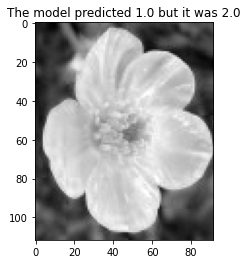

wrong prediction = 1 for 3 neighbours
accuracy for 300 non face images
Accuracy score is: 0.9942857142857143 for 3 neighbours


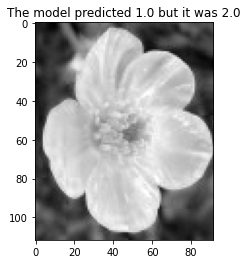

wrong prediction = 2 for 3 neighbours
accuracy for 400 non face images
Accuracy score is: 0.9875 for 3 neighbours


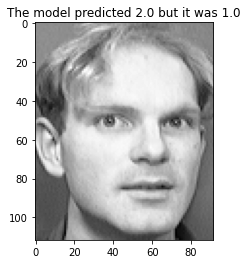

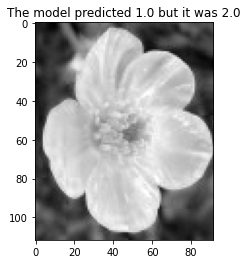

wrong prediction = 5 for 3 neighbours
accuracy for 500 non face images
Accuracy score is: 0.9911111111111112 for 3 neighbours


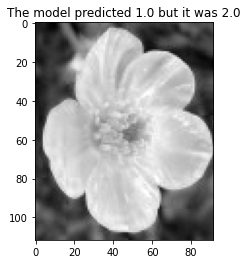

wrong prediction = 4 for 3 neighbours
accuracy for 600 non face images
Accuracy score is: 0.98 for 3 neighbours


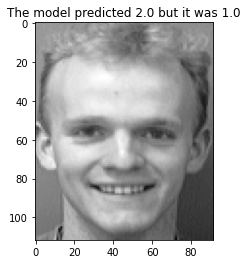

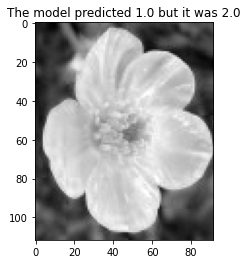

wrong prediction = 10 for 3 neighbours


In [ ]:
yy = [100, 200, 300, 400, 500, 600]
accuracy = LDA_non_faces_vs_faces_benchmark(faces = data, non_faces = non_faces, num_non_faces = yy, caches = caches)

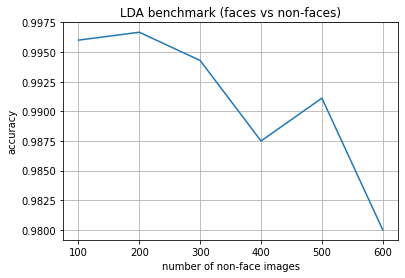

In [ ]:
plt.plot(yy, accuracy)
plt.ylabel('accuracy')
plt.xlabel('number of non-face images')
plt.title('LDA benchmark (faces vs non-faces)')
plt.grid()
plt.show()

In [ ]:
def PCA_non_faces_vs_faces_benchmark(faces, non_faces, num_non_faces, caches = []):
  '''
  This function is to answer question 7)a)iii 
  num_non_faces: a list of how many non_face images will be used per iteration
  faces: the faces dataset
  non_faces: the non faces dataset
  returns:
    accuracy_per_num_non_faces: a list of the accuracies per the elements in num_non_faces list
    caches = a list of the caches for each iteration of LDA
  '''
  accuracy_per_num_non_faces = []
  # np.random.seed(112)
  # np.random.shuffle(non_faces)
  for n in num_non_faces:
    x = []
    # get dataset having n number of non_face images n will be [100, 200, 300, 400, 500, 600]
    new_data, new_labels = create_new_dataset(faces = faces, non_faces = non_faces[:n])
    # use 50-50 split to split new_data into train and test data
    new_train_data, new_train_labels, new_test_data, new_test_labels = custom_train_test_split(new_data, new_labels)
    # perform PCA
    A_train1, A_test1, x = PCA(new_train_data, new_test_data, alphas = [0.85], cache = x)
    # get accuracy by KNN for k_neighbours = 3
    print(f"accuracy for {n} non face images")
    acc = K_nearest_neighbours(A_train1[0], new_train_labels, A_test1[0], new_test_labels, k_neighbours = [3], benchmark = True, alpha = 0.85, original_test_data = new_test_data)
    print("========================================================")
    # append the acc to the accuracy list so that we can plot it when the loop is finished
    accuracy_per_num_non_faces.append(acc)
  
  return accuracy_per_num_non_faces

accuracy for 100 non face images
Accuracy score is: 0.988 for 3 neighbours


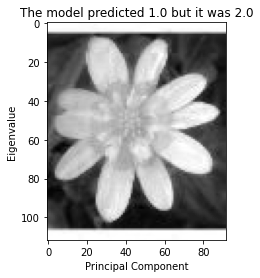

wrong prediction = 3 for 3 neighbours
accuracy for 200 non face images
Accuracy score is: 0.9933333333333333 for 3 neighbours


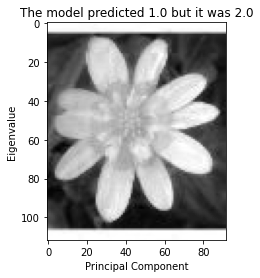

wrong prediction = 2 for 3 neighbours
accuracy for 300 non face images
Accuracy score is: 0.9914285714285714 for 3 neighbours


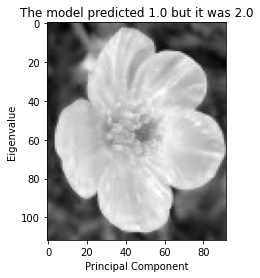

wrong prediction = 3 for 3 neighbours
accuracy for 400 non face images
Accuracy score is: 0.99 for 3 neighbours


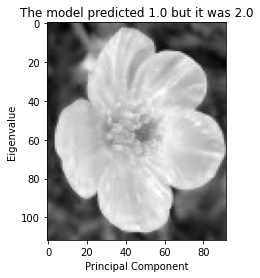

wrong prediction = 4 for 3 neighbours
accuracy for 500 non face images
Accuracy score is: 0.9911111111111112 for 3 neighbours


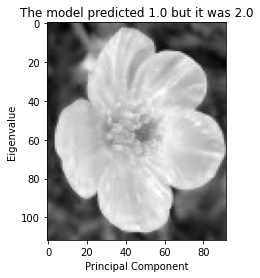

wrong prediction = 4 for 3 neighbours
accuracy for 600 non face images
Accuracy score is: 0.984 for 3 neighbours


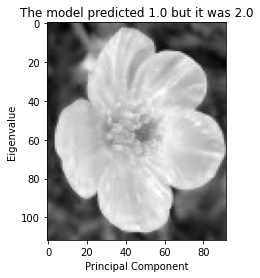

wrong prediction = 8 for 3 neighbours


In [ ]:
yy = [100, 200, 300, 400, 500, 600]
caches = []
accuracy_PCA = PCA_non_faces_vs_faces_benchmark(faces = data, non_faces = non_faces, num_non_faces = yy, caches = caches)

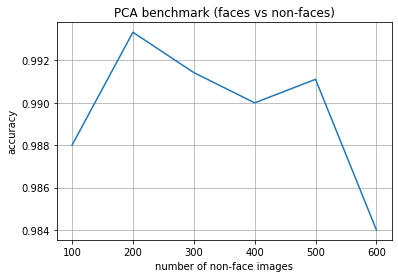

In [ ]:
plt.plot(yy, accuracy_PCA)
plt.ylabel('accuracy')
plt.xlabel('number of non-face images')
plt.title('PCA benchmark (faces vs non-faces)')
plt.grid()
plt.show()

# (Bonus) 7:3 split for training and testing data

In [ ]:
def unbalanced_train_test_split(data, labels):
  '''
  This function performs a 70%-30% split for training and testing data
  returns a tuple:
    train_data
    train_labels
    test_data
    test_labels
  '''
  train_data = np.zeros((int(data.shape[0]*(7/10)), data.shape[1]))
  test_data = np.zeros((int(data.shape[0]*(3/10)), data.shape[1]))
  train_labels = np.zeros((int(labels.shape[0]*(7/10))))
  test_labels = np.zeros((int(labels.shape[0]*(3/10))))
  i = 0
  j = 0
  for index in range(data.shape[0]):
    if index%10 > 6:
      test_data[i] = data[index]
      test_labels[i] = labels[index]
      i+=1
    else:
      train_data[j] = data[index]
      train_labels[j] = labels[index]
      j+=1
  return train_data, train_labels, test_data, test_labels

In [ ]:
train_data_unbalanced, train_labels_unbalanced, test_data_unbalanced, test_labels_unbalanced = unbalanced_train_test_split(data, labels)
print(train_data_unbalanced.shape)
print(test_data_unbalanced.shape)
print(train_labels_unbalanced.shape)
print(test_labels_unbalanced.shape)


(280, 10304)
(120, 10304)
(280,)
(120,)


# (Bonus) Running PCA and it's classification

In [ ]:
try: 
  print(len(cache2))
except NameError:
  cache2 = []

1


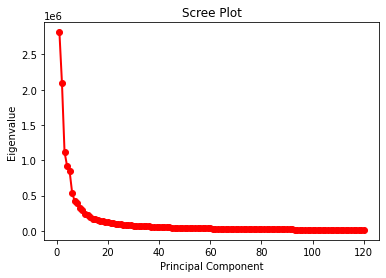

In [ ]:
alphas = [0.8, 0.85, 0.9, 0.95]
A_train_per_alpha, A_test_per_alpha, cache2  = PCA(train_data_unbalanced, test_data_unbalanced, alphas, cache2)

Accuracy score is: 0.95 for 1 neighbours
wrong prediction = 6 for 1 neighbours
Accuracy score is: 0.9333333333333333 for 3 neighbours
wrong prediction = 8 for 3 neighbours
Accuracy score is: 0.9166666666666666 for 5 neighbours
wrong prediction = 10 for 5 neighbours
Accuracy score is: 0.8416666666666667 for 7 neighbours
wrong prediction = 19 for 7 neighbours


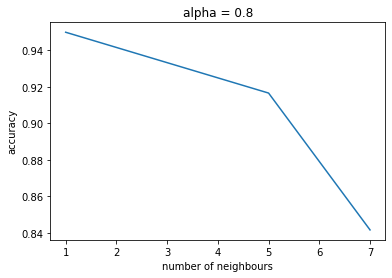

Accuracy score is: 0.9583333333333334 for 1 neighbours
wrong prediction = 5 for 1 neighbours
Accuracy score is: 0.925 for 3 neighbours
wrong prediction = 9 for 3 neighbours
Accuracy score is: 0.9083333333333333 for 5 neighbours
wrong prediction = 11 for 5 neighbours
Accuracy score is: 0.825 for 7 neighbours
wrong prediction = 21 for 7 neighbours


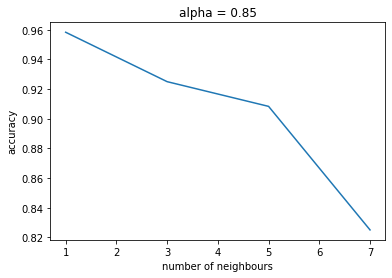

Accuracy score is: 0.95 for 1 neighbours
wrong prediction = 6 for 1 neighbours
Accuracy score is: 0.9166666666666666 for 3 neighbours
wrong prediction = 10 for 3 neighbours
Accuracy score is: 0.9166666666666666 for 5 neighbours
wrong prediction = 10 for 5 neighbours
Accuracy score is: 0.8333333333333334 for 7 neighbours
wrong prediction = 20 for 7 neighbours


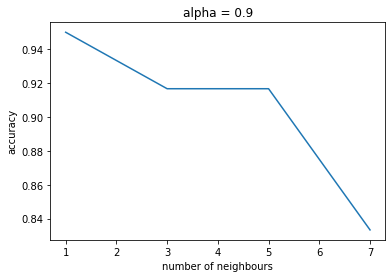

Accuracy score is: 0.95 for 1 neighbours
wrong prediction = 6 for 1 neighbours
Accuracy score is: 0.9 for 3 neighbours
wrong prediction = 12 for 3 neighbours
Accuracy score is: 0.9 for 5 neighbours
wrong prediction = 12 for 5 neighbours
Accuracy score is: 0.8333333333333334 for 7 neighbours
wrong prediction = 20 for 7 neighbours


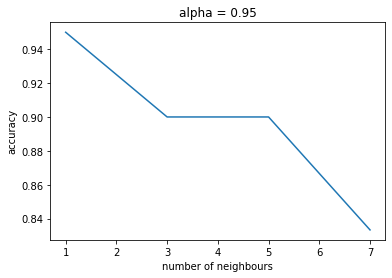

In [ ]:
k_neighbours = [1, 3, 5, 7]
for A_train, A_test, alpha in zip(A_train_per_alpha, A_test_per_alpha, alphas):
  K_nearest_neighbours(A_train, train_labels_unbalanced, A_test, test_labels_unbalanced, k_neighbours, alpha)

# (Bonus) Run LDA

In [ ]:
try:
  print(len(cache1))
except NameError:
  cache1 = []

1


In [ ]:
A_train, A_test, cache1 = LDA(train_data_unbalanced, train_labels_unbalanced, test_data_unbalanced, num_classes=40, cache = cache1)

Accuracy score is: 0.95 for 1 neighbours
wrong prediction = 6 for 1 neighbours
Accuracy score is: 0.9 for 3 neighbours
wrong prediction = 12 for 3 neighbours
Accuracy score is: 0.825 for 5 neighbours
wrong prediction = 21 for 5 neighbours
Accuracy score is: 0.8 for 7 neighbours
wrong prediction = 24 for 7 neighbours


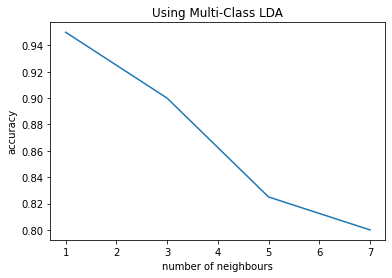

In [ ]:
k_neighbours = [1, 3, 5, 7]
K_nearest_neighbours(A_train, train_labels_unbalanced, A_test, test_labels_unbalanced, k_neighbours)